In [2]:
from pathlib import Path

import kagglehub
import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import (
    preprocess_input as mobilenet_preprocess_input,
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
DATA_DIR = kagglehub.dataset_download("arjuntejaswi/plant-village")
DATA_PATH = Path(DATA_DIR) / "PlantVillage"

print(f"Using dataset from: {DATA_PATH}")

100%|██████████| 329M/329M [00:09<00:00, 37.9MB/s]

Extracting files...


Using dataset from: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1/PlantVillage


In [4]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
VALIDATION_SPLIT = 0.2

# Load and split data
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    subset="training",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Prefetching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(
    f"Training dataset size: {tf.data.experimental.cardinality(train_ds).numpy()} batches"
)
print(
    f"Validation dataset size: {tf.data.experimental.cardinality(val_ds).numpy()} batches"
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Number of classes: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Training dataset size: 516 batches
Validation dataset size: 129 batches


In [5]:
augmenter = keras.Sequential(
    [
        keras_cv.layers.RandomFlip("horizontal"),
        keras_cv.layers.RandomRotation(factor=0.1),
        keras_cv.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 255)),
    ],
    name="augmenter",
)


def preprocess_data(
    images: tf.Tensor, labels: tf.Tensor
) -> tuple[tf.Tensor, tf.Tensor]:
    """Applies augmentation to images."""
    augmented_images = augmenter(images)
    return augmented_images, labels


train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

In [6]:
# Base Model
base_model = keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

# Build the new model
inputs = keras.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = mobilenet_preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
x = layers.Dropout(0.3, name="dropout_layer")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model = keras.Model(inputs, outputs, name="plant_disease_classifier")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
LOG_DIR = "logs"
Path(LOG_DIR).mkdir(parents=True, exist_ok=True)

# Callbacks
model_checkpoint_cb = ModelCheckpoint(
    filepath=Path(LOG_DIR) / "transfer_learning" / "best_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
)

early_stopping_cb = EarlyStopping(
    patience=5, restore_best_weights=True, monitor="val_loss", mode="min", verbose=1
)

reduce_lr_on_plateau_cb = ReduceLROnPlateau(
    patience=3, factor=0.5, verbose=1, monitor="val_loss", mode="min"
)

tensorboard_cb_tl = TensorBoard(log_dir=Path(LOG_DIR) / "transfer_learning")

transfer_learning_callbacks = [
    model_checkpoint_cb,
    early_stopping_cb,
    reduce_lr_on_plateau_cb,
    tensorboard_cb_tl,
]

In [9]:
EPOCHS_TRANSFER_LEARNING = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TRANSFER_LEARNING,
    callbacks=transfer_learning_callbacks,
    verbose=1,
)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6032 - loss: 1.2786
Epoch 1: val_accuracy improved from -inf to 0.85171, saving model to logs/transfer_learning/best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 208s 382ms/step - accuracy: 0.6035 - loss: 1.2778 - val_accuracy: 0.8517 - val_loss: 0.4754 - learning_rate: 0.0010
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8352 - loss: 0.5181
Epoch 2: val_accuracy improved from 0.85171 to 0.87764, saving model to logs/transfer_learning/best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 188s 364ms/step - accuracy: 0.8352 - loss: 0.5180 - val_accuracy: 0.8776 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8599 - loss: 0.4252
Epoch 3: val_accuracy improved from 0.87764 to 0.87836, saving model to logs/transfer_learning/best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 199s 358ms/step - accuracy: 0.8599 - loss: 0.4252 - val_accuracy: 0.8784 - val_loss:

In [10]:
base_model.trainable = True

print(f"Trainable variables after unfreezing: {len(model.trainable_variables)}")

# Re-compile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

# Callbacks for Fine-tuning
model_checkpoint_cb_ft = ModelCheckpoint(
    filepath=Path(LOG_DIR) / "fine_tuning" / "best_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
)
tensorboard_cb_ft = TensorBoard(log_dir=Path(LOG_DIR) / "fine_tuning")

fine_tuning_callbacks = [
    model_checkpoint_cb_ft,
    early_stopping_cb,
    reduce_lr_on_plateau_cb,
    tensorboard_cb_ft,
]

Trainable variables after unfreezing: 158


Model: "plant_disease_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 2,243,087 (8.56 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
EPOCHS_FINE_TUNING = 10

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE_TUNING,
    callbacks=fine_tuning_callbacks,
    verbose=1,
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6194 - loss: 2.0264
Epoch 1: val_accuracy improved from -inf to 0.86189, saving model to logs/fine_tuning/best_model.keras
516/516 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - accuracy: 0.6196 - loss: 2.0249 - val_accuracy: 0.8619 - val_loss: 0.4429 - learning_rate: 1.0000e-05
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8401 - loss: 0.5166
Epoch 2: val_accuracy did not improve from 0.86189
516/516 ━━━━━━━━━━━━━━━━━━━━ 215s 369ms/step - accuracy: 0.8402 - loss: 0.5166 - val_accuracy: 0.8544 - val_loss: 0.4684 - learning_rate: 1.0000e-05
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8750 - loss: 0.3825
Epoch 3: val_accuracy did not improve from 0.86189
516/516 ━━━━━━━━━━━━━━━━━━━━ 191s 368ms/step - accuracy: 0.8750 - loss: 0.3825 - val_accuracy: 0.8563 - val_loss: 0.4739 - learning_rate: 1.0000e-05
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9003 - loss: 0.2

Evaluating final model on the validation set:
  Validation Loss: 0.3655
  Validation Accuracy: 87.86%



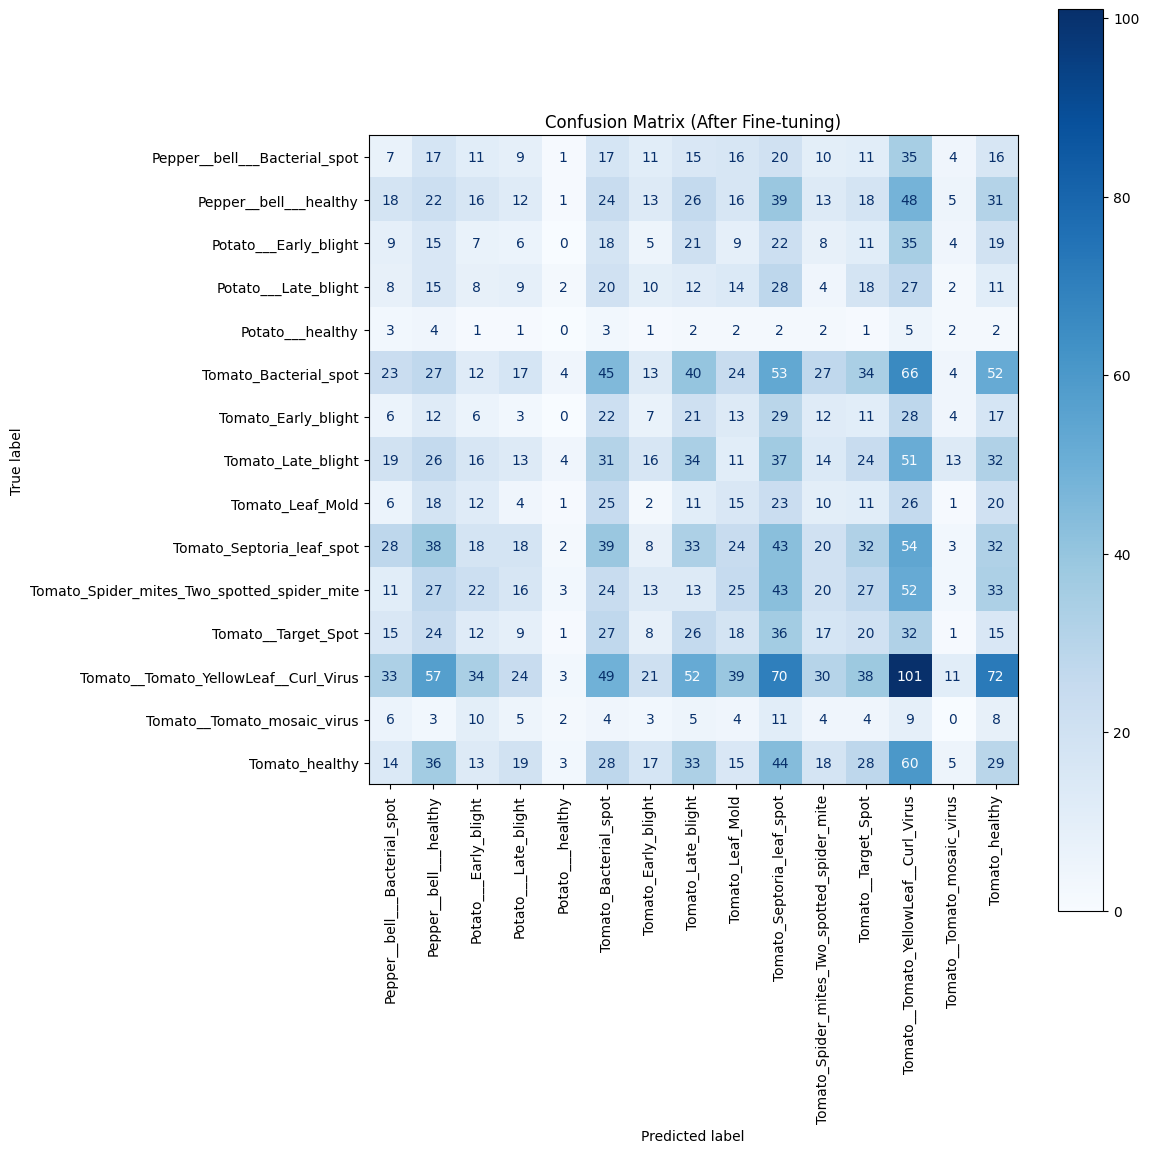

In [12]:
print("Evaluating final model on the validation set:")
loss, accuracy = model.evaluate(val_ds, verbose=0)
print(f"  Validation Loss: {loss:.4f}")
print(f"  Validation Accuracy: {accuracy * 100:.2f}%\n")

# Generate predictions for Confusion Matrix
val_labels_list = []
for _, labels_batch in val_ds:
    val_labels_list.append(labels_batch)
val_true_labels = tf.concat(val_labels_list, axis=0).numpy()

val_pred_probs = model.predict(val_ds, verbose=0)
val_pred_labels = tf.argmax(val_pred_probs, axis=1).numpy()

# Plot Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(xticks_rotation=90, cmap="Blues", ax=ax, values_format="d")
plt.title("Confusion Matrix (After Fine-tuning)")
plt.grid(False)
plt.tight_layout()
plt.show()

In [13]:
FINAL_MODEL_PATH = "best_model.keras"
model.save(FINAL_MODEL_PATH)
print(f"Final model saved to: {FINAL_MODEL_PATH}")

Final model saved to: best_model.keras
